# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


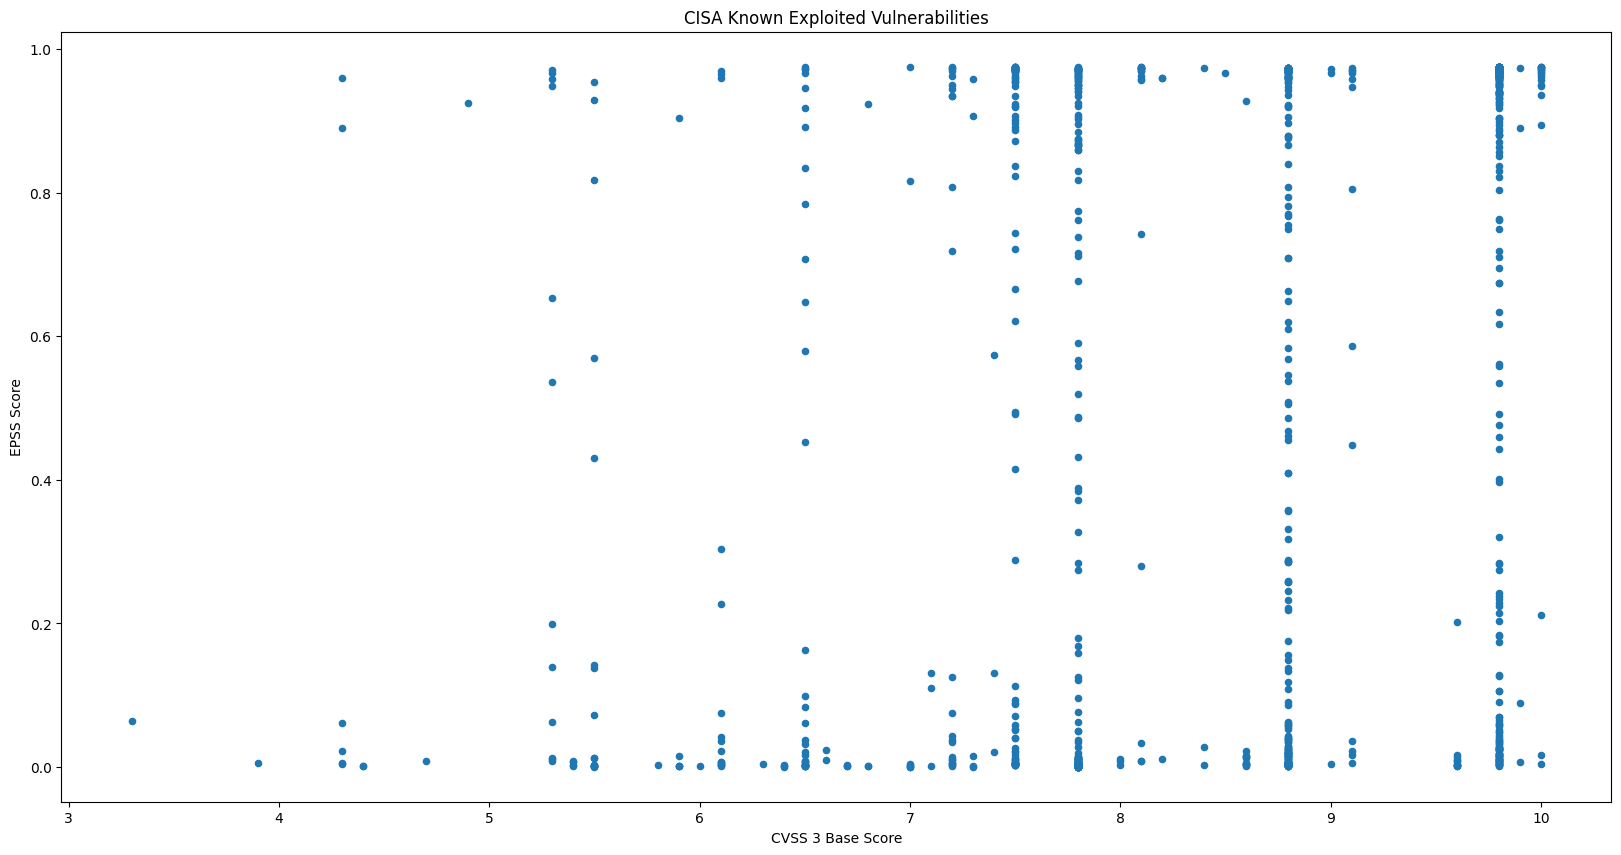

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CVS

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2024-35250,7.8,0.00043,0.11652,Microsoft Windows Kernel-Mode Driver contains ...,Microsoft,Windows
1,CVE-2024-20767,7.4,0.13142,0.95767,Adobe ColdFusion contains an improper access c...,Adobe,ColdFusion
2,CVE-2024-50623,NaN,0.04186,0.92552,"Cleo Harmony, VLTrader, and LexiCom, which are...",Cleo,Multiple Products
3,CVE-2024-49138,7.8,0.00154,0.53077,Microsoft Windows Common Log File System (CLFS...,Microsoft,Windows
4,CVE-2024-51378,9.8,0.00211,0.59968,CyberPanel contains an incorrect default permi...,CyberPersons,CyberPanel
5,CVE-2024-11667,9.8,0.01179,0.85711,Multiple Zyxel firewalls contain a path traver...,Zyxel,Multiple Firewalls
6,CVE-2024-11680,9.8,0.00259,0.66128,ProjectSend contains an improper authenticatio...,ProjectSend,ProjectSend
7,CVE-2023-45727,7.5,0.41475,0.97443,"North Grid Proself Enterprise/Standard, Gatewa...",North Grid,Proself
8,CVE-2023-28461,9.8,0.23791,0.96779,Array Networks AG and vxAG ArrayOS contain a m...,Array Networks,AG/vxAG ArrayOS
9,CVE-2024-21287,7.5,0.00631,0.79784,Oracle Agile Product Lifecycle Management (PLM...,Oracle,Agile Product Lifecycle Management (PLM)
